In [25]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns



### 1. Analyse exploratoire des données

In [2]:
# Chemins des dossiers (à adapter en fonction de l'emplacement des données)
train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

In [3]:

# Compter les images dans chaque sous-dossier
for subset_dir in [train_dir, val_dir, test_dir]:
    normal_count = len(os.listdir(os.path.join(subset_dir, "NORMAL")))
    pneumo_count = len(os.listdir(os.path.join(subset_dir, "PNEUMONIA")))
    subset_name = os.path.basename(subset_dir)
    print(f"{subset_name}: NORMAL={normal_count}, PNEUMONIA={pneumo_count}")


train: NORMAL=1341, PNEUMONIA=3875
val: NORMAL=8, PNEUMONIA=8
test: NORMAL=234, PNEUMONIA=390


Le jeu de données Chest X-Ray Images (Pneumonia) de Kaggle contient au total 5 863 radiographies thoraciques classées en deux catégories : NORMAL (sain) et PNEUMONIA (pneumonie). Les images sont réparties en trois sous-ensembles : train (entraînement), val (validation) et test. La distribution est la suivante :

* Entraînement : 5 216 images (1 341 Normal, 3 875 Pneumonia). On note un fort déséquilibre avec ~74% de cas de pneumonie (rapport ~1:3 Normal/Pneumonia).
* Validation : 16 images (8 Normal, 8 Pneumonia). Cet échantillon de validation est très petit (ce sont des radiographies vérifiées par un expert tiers pour garantir la qualité).
* Test : 624 images (234 Normal, 390 Pneumonia), utilisées pour l’évaluation finale du modèle.

In [4]:
# Netoyage des données

## Création des générateurs de données avec prétraitement

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


## Chargement des images par batch depuis les dossiers, avec cible 224x224

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


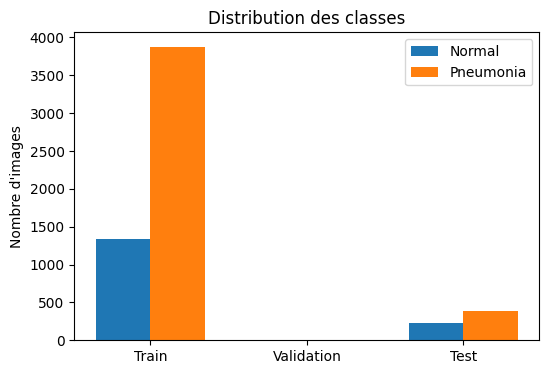

In [5]:
counts = {
    'Train': [1341, 3875],
    'Validation': [8, 8],
    'Test': [234, 390]
}
categories = ['Normal', 'Pneumonia']

fig, ax = plt.subplots(figsize=(6, 4))
index = np.arange(len(counts))
bar_width = 0.35

# Barres pour Normal et Pneumonia
normal_counts = [counts[s][0] for s in counts]
pneu_counts = [counts[s][1] for s in counts]

ax.bar(index, normal_counts, bar_width, label='Normal')
ax.bar(index + bar_width, pneu_counts, bar_width, label='Pneumonia')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(counts.keys())
ax.set_ylabel('Nombre d\'images')
ax.set_title('Distribution des classes')
ax.legend()
plt.show()

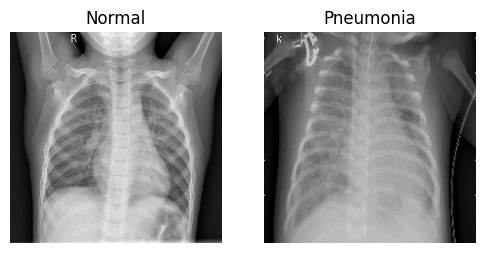

In [6]:
# Chemin d'un exemple de radio normale et d'une radio de pneumonie dans le dossier train
normal_example_path = os.path.join(
    train_dir, "NORMAL", os.listdir(os.path.join(train_dir, "NORMAL"))[0])
pneu_example_path = os.path.join(train_dir, "PNEUMONIA", os.listdir(
    os.path.join(train_dir, "PNEUMONIA"))[0])

normal_img = load_img(normal_example_path, target_size=(224, 224))
pneu_img = load_img(pneu_example_path, target_size=(224, 224))

# Conversion en tableau numpy pour affichage
normal_arr = img_to_array(normal_img)/255.0
pneu_arr = img_to_array(pneu_img)/255.0

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(normal_arr, cmap='gray')
axes[0].set_title("Normal")
axes[0].axis('off')
axes[1].imshow(pneu_arr, cmap='gray')
axes[1].set_title("Pneumonia")
axes[1].axis('off')
plt.show()

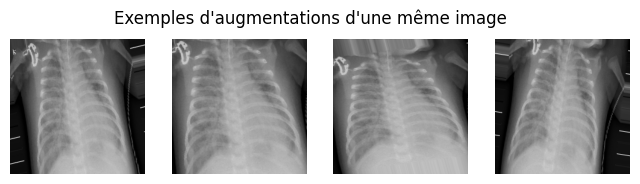

In [7]:
aug_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Charger une image de pneumonie
img_path = pneu_example_path  # assure-toi que ce chemin est défini
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)

# Afficher des versions augmentées
plt.figure(figsize=(8, 2))
aug_iter = aug_datagen.flow(img_array, batch_size=1)

for i in range(4):
    aug_img = next(aug_iter)[0]  # ⚠️ CORRECTION ICI
    plt.subplot(1, 4, i + 1)
    plt.imshow(aug_img / 1.0)  # déjà rescalé, sinon /255
    plt.axis('off')

plt.suptitle("Exemples d'augmentations d'une même image")
plt.show()

In [8]:
# Augmentation des donées

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,   # éventuellement décalage horizontal
    height_shift_range=0.1   # éventuellement décalage vertical
)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.


### 2. Comparaison des performances de trois modèles : 

In [9]:
# CNN

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # dropout pour régularisation
    Dense(1, activation='sigmoid')  # sortie binaire
])

model1.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])
model1.summary()

d:\Tp_efrei\Deep Learning\TP deep Learning 2\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entraînement du modèle CNN personnalisé
history1 = model1.fit(
    train_generator,
    # nombre de batches par epoch = images_train/32
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

d:\Tp_efrei\Deep Learning\TP deep Learning 2\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 839ms/step - accuracy: 0.7825 - loss: 0.5231 - val_accuracy: 0.7500 - val_loss: 0.6431
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 841ms/step - accuracy: 0.8723 - loss: 0.2991 - val_accuracy: 0.7500 - val_loss: 0.5588
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 829ms/step - accuracy: 0.8867 - loss: 0.2682 - val_accuracy: 0.7500 - val_loss: 0.4991
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 826ms/step - accuracy: 0.9028 - loss: 0.2416 - val_accuracy: 0.6875 - val_loss: 0.6929
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 823ms/step - accuracy: 0.9007 - loss: 0.2247 - val_accuracy: 0.7500 - val_loss: 0.6285
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 826ms/step - accuracy: 0.9115 - loss: 0.2234 - val_accuracy: 0.8750 - val_loss: 0.5040
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 839ms/step - accuracy: 0.9225 - loss: 0.1972 - val_accuracy: 0.8125 - val_loss: 0.5026
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 840ms/step - accuracy: 0.9181 -

In [11]:
# Modele 2 MobileNetV2

# Charger le modèle de base pré-entraîné
base_model = MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze du modèle de base

# Créer le nouveau modèle au sommet de MobileNetV2
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # important: en mode inference
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs, outputs)

model2.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])
model2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history2_phase1 = model2.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 814ms/step - accuracy: 0.8995 - loss: 0.2501 - val_accuracy: 0.9375 - val_loss: 0.2627
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 804ms/step - accuracy: 0.9374 - loss: 0.1568 - val_accuracy: 0.7500 - val_loss: 0.4664
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 794ms/step - accuracy: 0.9487 - loss: 0.1288 - val_accuracy: 0.8125 - val_loss: 0.2930
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 797ms/step - accuracy: 0.9568 - loss: 0.1143 - val_accuracy: 0.7500 - val_loss: 0.3458
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 805ms/step - accuracy: 0.9552 - loss: 0.1093 - val_accuracy: 0.8750 - val_loss: 0.2076


In [13]:
# Fine-tuning: unfreeze les 20 dernières couches du base_model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile le modèle avec un learning rate plus faible
model2.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history2_phase2 = model2.fit(
    train_generator,
    epochs=5,  # quelques époques supplémentaires
    validation_data=val_generator
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 885ms/step - accuracy: 0.8960 - loss: 0.2389 - val_accuracy: 0.8125 - val_loss: 0.3101
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 881ms/step - accuracy: 0.9343 - loss: 0.1625 - val_accuracy: 0.8125 - val_loss: 0.4265
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 883ms/step - accuracy: 0.9460 - loss: 0.1211 - val_accuracy: 0.7500 - val_loss: 0.6907
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 894ms/step - accuracy: 0.9584 - loss: 0.1083 - val_accuracy: 0.7500 - val_loss: 0.8393
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 919ms/step - accuracy: 0.9493 - loss: 0.1221 - val_accuracy: 0.6875 - val_loss: 0.9730


In [15]:
# ResNet50 
base_model_resnet = ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, outputs)

model3.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])
model3.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# Fine-tuning:

for layer in base_model_resnet.layers[-10:]:
    layer.trainable = True
model3.compile(optimizer=Adam(1e-5),
               loss='binary_crossentropy', metrics=['accuracy'])

### 3. Comparaison des modèle : 

In [23]:
def evaluate_model(model, model_name, test_generator):
    print(f"\n🧠 Évaluation du {model_name}")

    # Prédictions (probabilités)
    y_prob = model.predict(test_generator)
    y_pred = (y_prob > 0.5).astype(int).reshape(-1)
    y_true = test_generator.classes

    # Score global
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} - Test Accuracy: {acc:.4f} - Loss: {loss:.4f}\n")

    # Rapport de classification
    print("📊 Rapport de classification:")
    print(classification_report(y_true, y_pred,
          target_names=["NORMAL", "PNEUMONIA"]))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbe ROC - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

    return {
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "AUC": round(auc, 4)
    }


🧠 Évaluation du CNN personnalisé
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step
CNN personnalisé - Test Accuracy: 0.9071 - Loss: 0.2387

📊 Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.87      0.88      0.88       234
   PNEUMONIA       0.93      0.92      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



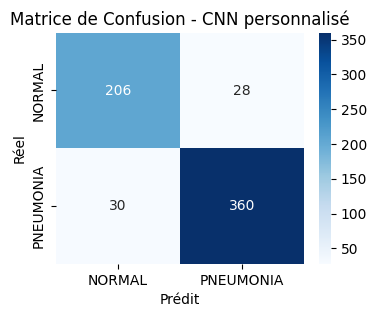

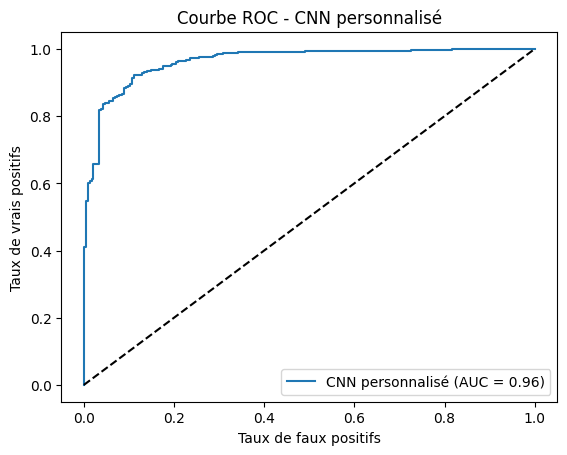


🧠 Évaluation du MobileNetV2
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 842ms/step
MobileNetV2 - Test Accuracy: 0.8413 - Loss: 0.6441

📊 Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.97      0.59      0.74       234
   PNEUMONIA       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



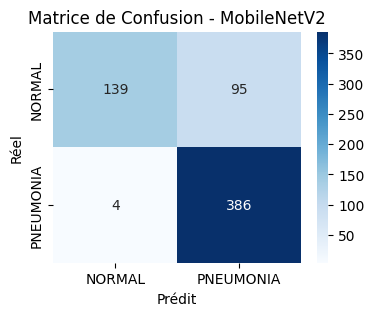

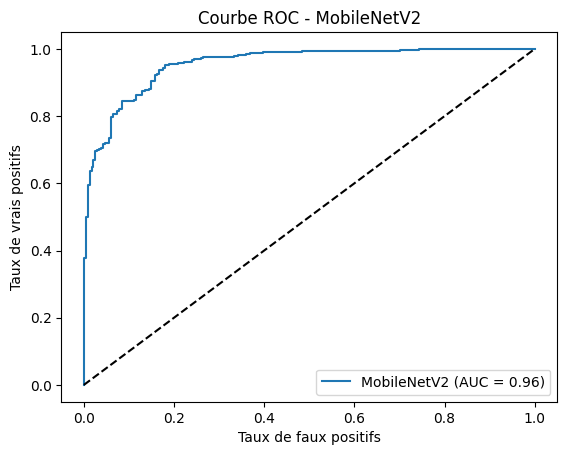


🧠 Évaluation du ResNet50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
ResNet50 - Test Accuracy: 0.6250 - Loss: 1.1322

📊 Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



d:\Tp_efrei\Deep Learning\TP deep Learning 2\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Tp_efrei\Deep Learning\TP deep Learning 2\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Tp_efrei\Deep Learning\TP deep Learning 2\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

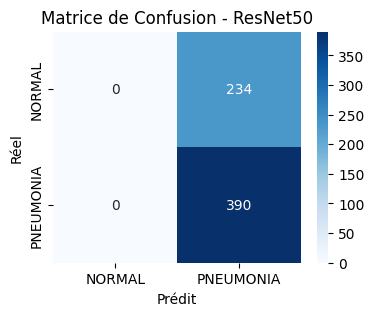

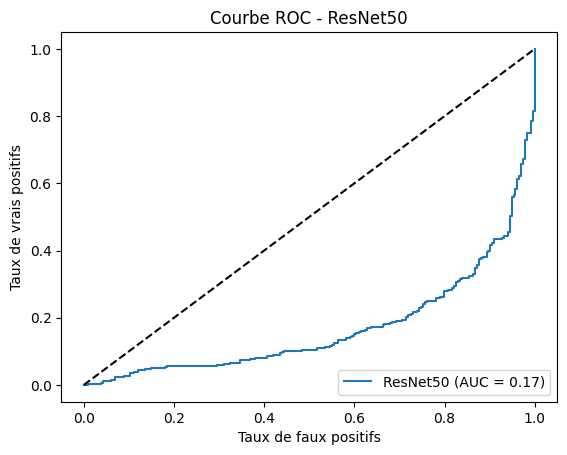

In [24]:
results = []
results.append(evaluate_model(model1, "CNN personnalisé", test_generator))
results.append(evaluate_model(model2, "MobileNetV2", test_generator))
results.append(evaluate_model(model3, "ResNet50", test_generator))

In [26]:
df_results = pd.DataFrame(results)
display(df_results)

,Model,Accuracy,AUC
0,CNN personnalisé,0.9071,0.9636
1,MobileNetV2,0.8413,0.9550
2,ResNet50,0.6250,0.1694


In [27]:
df_results.sort_values(by="Accuracy", ascending=False, inplace=True)
print("🔎 Résumé trié par précision sur le test :")
print(df_results)

🔎 Résumé trié par précision sur le test :
              Model  Accuracy     AUC
0  CNN personnalisé    0.9071  0.9636
1       MobileNetV2    0.8413  0.9550
2          ResNet50    0.6250  0.1694


In [28]:
#Sauvegarde des modèles
model1.save("models/model_CNN_custom.h5")
model2.save("models/model_MobileNetV2.h5")
model3.save("models/model_ResNet50.h5")